In [ ]:
import copy
import pickle

import jax.nn
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import optax
import tqdm.notebook as tqdm
from numpyro import handlers

In [ ]:
%load_ext autoreload
%autoreload 2

from experiments.src.experiment import *
from experiments.src.data import DataSlice, ToyData1, Sign
from experiments.src.model import BNNRegressor

In [ ]:
# %matplotlib inline
# import matplotlib
# matplotlib.use("nbAgg")  # noqa: E402

plt.rcParams.update({
    "axes.grid": True,      # show grid by default
    "font.weight": "bold",  # bold fonts
    "xtick.labelsize": 15,  # large tick labels
    "ytick.labelsize": 15,  # large tick labels
    "lines.linewidth": 1,   # thick lines
    "lines.color": "k",     # black lines
    # "grid.color": "0.5",    # gray gridlines
    "grid.linestyle": "-",  # solid gridlines
    "grid.linewidth": 0.1,  # thin gridlines
    "savefig.dpi": 300,     # higher resolution output.
})

In [34]:
DEVICE = "cpu"
numpyro.set_platform(DEVICE)
# numpyro.set_host_device_count(NUM_CHAINS)
D_X = 2
VI_MAX_ITER = 15_000
BNN_SIZE = [16, 16]
BETA = .5
# FIG_PREFIX = f"fig"

## Data

In [33]:
data = Sign(ToyData1(D_X=D_X, train_size=100, sigma_obs=0.1))

## Model

In [35]:
bnn = BNNRegressor(
    nonlin=jax.nn.silu,
    D_X=D_X,
    D_Y=2,
    D_H=BNN_SIZE,
    biases=True,
    prior_scale=10,
    prior_type='xavier',
    obs_model="classification",
    # obs_model='loc_scale',
    # obs_model=1 / (0.05 / 0.26480442)**2,
    beta=BETA,
)


In [36]:
bnn.get_weight_dim()

354

In [42]:
hmc_experiment = BasicHMCExperiment(bnn, data, num_samples=1_000, num_warmup=500)
hmc_experiment.train(random.PRNGKey(0))

sample: 100%|██████████| 1500/1500 [02:07<00:00, 11.74it/s, 1023 steps of size 2.18e-03. acc. prob=0.97]



MCMC elapsed time: 132.2159869670868


In [43]:
hmc_experiment.make_predictions(random.PRNGKey(2))

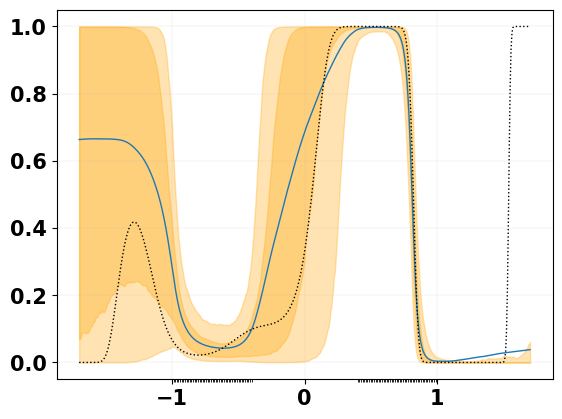

In [45]:
fig, ax = plt.subplots()
hmc_experiment.make_plots(fig=fig, ax=ax)
fig.savefig("figs/bin_hmc.png")

In [51]:
vi_experiment = BasicMeanFieldGaussianVIExperiment(bnn, data, num_samples=10_000, max_iter=100_000)
vi_experiment.train(random.PRNGKey(0))

Initial eval loss: 1992.8325 (lik: -67.1994, kl: 1925.6331)


100%|██████████| 50/50 [05:15<00:00,  6.31s/it, init loss: 1992.8323, avg. train loss / eval. loss [98000-100000]: 68.1611 / 67.3488]


SVI elapsed time: 315.550776720047


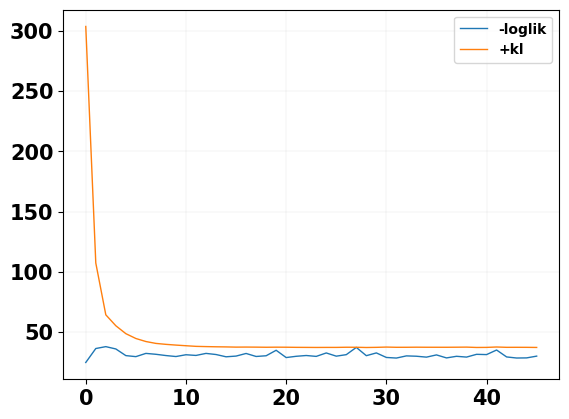

In [60]:
fig, ax = plt.subplots()
ax.plot(-vi_experiment._eval_losses[4:, 1], label="-loglik")
ax.plot(vi_experiment._eval_losses[4:, 2], label="+kl")
ax.legend()
# fig.savefig("figs/bin_conv.png")
plt.show()

In [61]:
vi_experiment.make_predictions(random.PRNGKey(2))

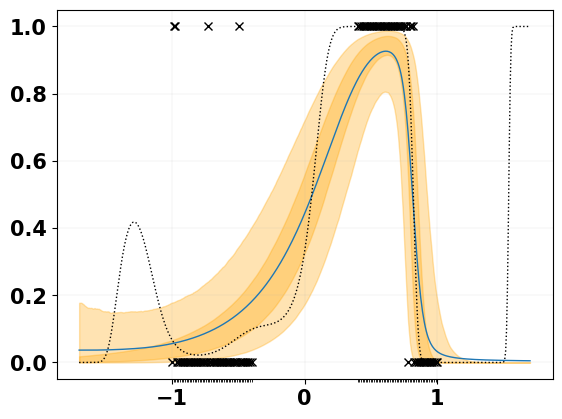

In [63]:
fig, ax = plt.subplots()
vi_experiment.make_plots(fig=fig, ax=ax)
ax.plot(data.train[0][:, 1], data.train[1], 'kx')
# fig.savefig("figs/bin_full.png")
plt.show()

In [37]:
sequential_experiment = SequentialExperiment(bnn, data, BasicMeanFieldGaussianVIExperiment, num_inference_steps=5, max_iter = VI_MAX_ITER, num_samples=10_000)

In [38]:
# sequential_experiment = ExperimentWithLastBlockReplaced(sequential_experiment, BasicHMCExperiment, num_samples=200, num_warmup=100)

In [39]:
sequential_experiment.train(random.PRNGKey(0))

Initial eval loss: 1943.0155 (lik: -14.6529, kl: 1928.3625)


100%|██████████| 50/50 [00:45<00:00,  1.10it/s, init loss: 1943.0155, avg. train loss / eval. loss [14700-15000]: 29.9529 / 30.1431]  



SVI elapsed time: 46.08302092552185
Initial eval loss: 1926.1779 (lik: -15.5177, kl: 1910.6602)


100%|██████████| 50/50 [00:35<00:00,  1.41it/s, init loss: 1926.1779, avg. train loss / eval. loss [14700-15000]: 5.9006 / 6.0340]    



SVI elapsed time: 35.634498834609985
Initial eval loss: 1927.3937 (lik: -14.1538, kl: 1913.2399)


100%|██████████| 50/50 [00:42<00:00,  1.19it/s, init loss: 1927.3940, avg. train loss / eval. loss [14700-15000]: 12.2807 / 12.5501]  



SVI elapsed time: 42.24294924736023
Initial eval loss: 1950.5675 (lik: -16.7325, kl: 1933.8350)


100%|██████████| 50/50 [00:33<00:00,  1.49it/s, init loss: 1950.5676, avg. train loss / eval. loss [14700-15000]: 0.4603 / 0.1624]    



SVI elapsed time: 33.79884314537048
Initial eval loss: 1945.5000 (lik: -10.8102, kl: 1934.6898)


100%|██████████| 50/50 [00:40<00:00,  1.23it/s, init loss: 1945.5000, avg. train loss / eval. loss [14700-15000]: 26.2808 / 25.7530]  


SVI elapsed time: 40.69088816642761


In [40]:
sequential_experiment.make_predictions(random.PRNGKey(2), final_only=False)

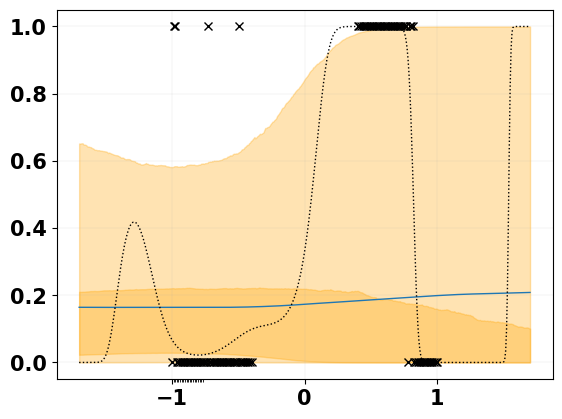

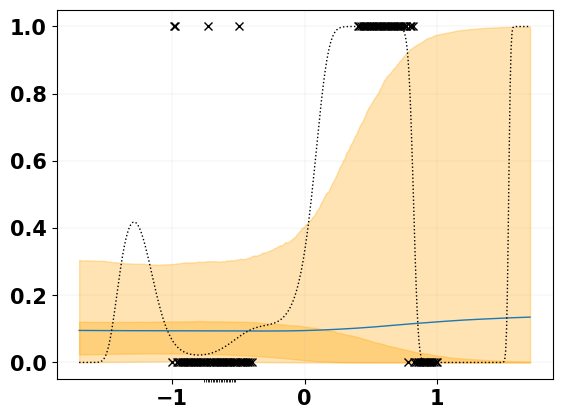

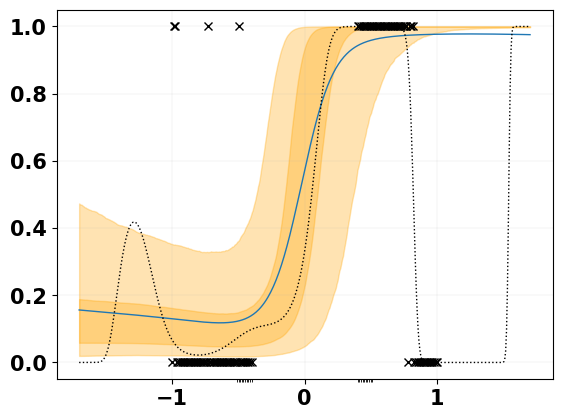

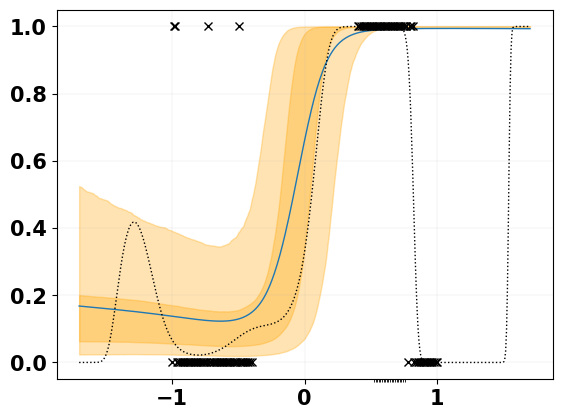

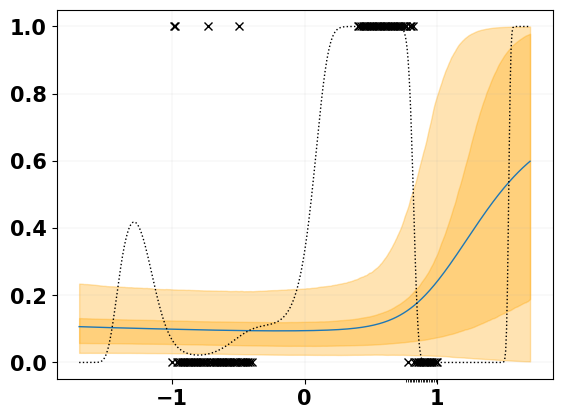

In [46]:
for i, experiment_block in enumerate(sequential_experiment._experiment_blocks):
    fig, ax = plt.subplots()
    experiment_block.make_plots(fig, ax)
    # plot prior data
    end = experiment_block._data._train_idx_slice.start
    ax.plot(sequential_experiment._data.train[0][:, 1], sequential_experiment._data.train[1], 'kx')
    fig.savefig(f"figs/seqbin{i}.png")
    plt.show()

In [ ]:
# # Custom plotting for sequential experiment
# fig, axs = plt.subplots(figsize=(20, 8), ncols=3)
# for i, ax in enumerate(axs.ravel()):
#     experiment_block = sequential_experiment._sequential_experiment._experiment_blocks[i]
#     predictions = experiment_block._predictions["Y"][..., 0]
#     mean_predictions = experiment_block._predictions["Y_mean"][..., 0]
#     data = experiment_block._data
#     X, Y = data.train
#     X_test, _ = data.test
#     # compute mean prediction and confidence interval around median
#     mean_means = jnp.mean(mean_predictions, axis=0)
#     mean_percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)
#     # plot training data
#     ax.plot(X[:, 1], Y[:, 0], "kx")
#     # plot predictions & quantiles
#     ax.plot(X_test[:, 1], mean_means, color="blue")
#     ax.fill_between(X_test[:, 1], *mean_percentiles, color="lightblue")
#     ax.set_title(str(data._train_idx_slice))
# fig.tight_layout()
# fig.savefig("figs/sequential-VI-simple3.png")